### Imports

In [46]:
import sys
sys.path.append('../src')

import data_utils


import matplotlib.pyplot  as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import platform
import cv2
import tensorflow as tf
import IPython.display as display
import os

from skimage import io, feature, util, color
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from tensorflow import keras
from PIL import Image
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [47]:
# Read datasets
main_data = pd.read_csv("../data/raw/data_labels_mainData.csv")
extra_data = pd.read_csv("../data/raw/data_labels_extraData.csv")

# Read patient images 
image_folder = "../data/raw/patch_images"
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]

# 3. Train-Test-Split
----

**Functions:**

In [48]:
def split_dataset(main_data, train_ratio, val_ratio):
    """
    Split the main_data DataFrame into training, validation, and testing sets based on the patientID column.

    Parameters:
    main_data (DataFrame): the DataFrame containing the image data
    train_ratio (float): the proportion of data to allocate to the training set (e.g., 0.7 for 70%)
    val_ratio (float): the proportion of data to allocate to the validation set (e.g., 0.15 for 15%)

    Returns:
    train_data (DataFrame): the subset of main_data containing the training data
    val_data (DataFrame): the subset of main_data containing the validation data
    test_data (DataFrame): the subset of main_data containing the testing data
    """

    # Set the random seed for reproducibility to student id
    np.random.seed(88)
    
    # Extract the unique patient IDs from your dataset
    unique_patients = np.unique(main_data['patientID'])

    # Shuffle the patient IDs
    np.random.shuffle(unique_patients)

    # Split the list of patient IDs into three disjoint sets
    train_patients, val_test_patients = np.split(unique_patients, [int(len(unique_patients)*train_ratio)])

    val_patients, test_patients = np.split(val_test_patients, [int(len(val_test_patients)*val_ratio)])

    # Finally, use the patient ID sets to filter the original dataset into training, validation, and testing sets
    train_data = main_data[main_data['patientID'].isin(train_patients)]
    val_data = main_data[main_data['patientID'].isin(val_patients)]
    test_data = main_data[main_data['patientID'].isin(test_patients)]

    return train_data, val_data, test_data

def plot_dataset_distributions(train_data, val_data, test_data, class_columns):
    """
    Plot the distributions of the given columns for the three datasets.

    Parameters:
    train_data (DataFrame): the training dataset
    val_data (DataFrame): the validation dataset
    test_data (DataFrame): the testing dataset
    class_columns (list): a list of column names to plot distributions for

    Returns:
    None
    """

    # Set up the subplots
    fig, axs = plt.subplots(len(class_columns), 3, figsize=(15, 5*len(class_columns)))

    # Loop over each class column
    for i, col in enumerate(class_columns):
        # Plot the distribution for the training set
        axs[i][0].hist(train_data[col], bins=10, color='blue')
        axs[i][0].set_title(f"Training Set - {col} Distribution")

        # Plot the distribution for the validation set
        axs[i][1].hist(val_data[col], bins=10, color='green')
        axs[i][1].set_title(f"Validation Set - {col} Distribution")

        # Plot the distribution for the testing set
        axs[i][2].hist(test_data[col], bins=10, color='orange')
        axs[i][2].set_title(f"Testing Set - {col} Distribution")

    # Set the title of the entire plot
    fig.suptitle("Distribution of Dataset Classes for each set.", fontsize=16)

    # Show the plot
    plt.show()

### 3.1 Splitting by Patient ID
----

Because we observed the similarity between the images from a same patienID, we conclude that if we include images of the same patient in both the training and testing sets, data leakage might be introduced, since the model may simply memorize the images of the patients in the training set rather than learning to recognize general patterns that can be applied to new, unseen patients. To avoid this we ensure that there is no overlap between the images of patients in the sets by spliting by patientID.

Splitting the data by patient ID can also make easier to add new data to the model. When we split the data by patient ID, we can train the model on a subset of the data and then evaluate its performance on a separate subset of the data. If we later acquire new data from additional patients, we can simply add it to the training set and retrain the model. The model will then learn to recognize patterns specific to these new patients and should improve its performance on new, unseen images.

In [49]:
train_data, val_data, test_data = split_dataset(main_data, train_ratio=0.7, val_ratio=0.55)

# Print the shapes of the resulting datasets
print("Train: ", train_data.shape)
print("Val:   ", val_data.shape)
print("Test:  ",test_data.shape)
print()

Train:  (7360, 6)
Val:    (1241, 6)
Test:   (1295, 6)



- **Sanity check** below to ensure that no patient IDs are present in more than one dataset (train, validation, or test). If any IDs are present in more than one dataset, it could lead to data leakage and affect the accuracy of the model's evaluation.

In [50]:
train_patients = set(train_data['patientID'].unique())
val_patients = set(val_data['patientID'].unique())
test_patients = set(test_data['patientID'].unique())

try:
    assert len(train_patients.intersection(val_patients)) == 0
    assert len(train_patients.intersection(test_patients)) == 0
    assert len(val_patients.intersection(test_patients)) == 0
    print("No patient ID is present in more than one dataset.")
except AssertionError:
    print("Error: some patient IDs are present in multiple datasets.")

No patient ID is present in more than one dataset.


### 3.2 Evaluating the distribution in our splits
----

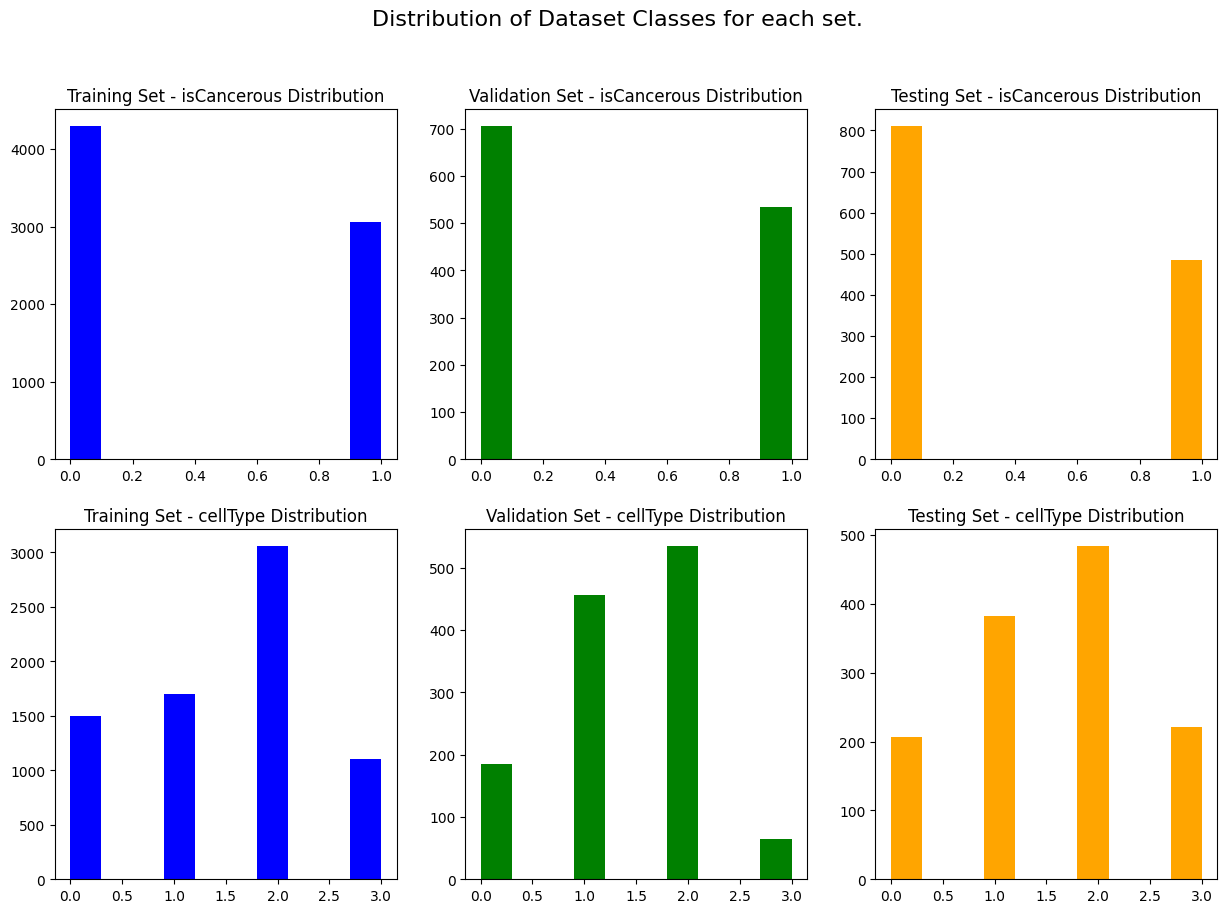

In [51]:
class_columns = ['isCancerous', 'cellType']
plot_dataset_distributions(train_data, val_data, test_data, class_columns)

# 4. Image Preprocessing
----


We should consider, while the model may learn to recognize specific patterns that are unique to the images from the patients in the training set, these features may not apply to images from new patients. To address this, we can consider using techniques to address the potential for overfitting, such as regularization or data augmentation to artificially increase the variation in the images. These techniques can help ensure that the model learns to recognize general patterns that are not unique to specific patients, and can help improve its ability to generalize to new, unseen patients.

To prepare the image data for use in a CNN, we will perform image preprocessing steps such as resizing, normalization, and augmentation, to improve the quality and quantity of the data.  Then pass the preprocessed images through the CNN model, which would learn to extract features from the images and classify them based on their cellType or isCancerous.

**Functions:**

In [52]:
#  Preprocesses the image data and returns a dictionary containing the preprocessed train, validation, and test data:
def preprocess_data(image_folder, train_data, val_data, test_data, target_size, batch_size):
    # Get the list of image paths for each set
    train_image_paths = [os.path.join(image_folder, filename) for filename in train_data['ImageName'].values]
    val_image_paths = [os.path.join(image_folder, filename) for filename in val_data['ImageName'].values]
    test_image_paths = [os.path.join(image_folder, filename) for filename in test_data['ImageName'].values]

    # Create data generators for each set
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        train_data,
        directory=image_folder,
        x_col='ImageName',
        y_col='cellType',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_dataframe(
        val_data,
        directory=image_folder,
        x_col='ImageName',
        y_col='cellType',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_dataframe(
        test_data,
        directory=image_folder,
        x_col='ImageName',
        y_col='cellType',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Define the output dictionary
    output = {
        'train_generator': train_generator,
        'val_generator': val_generator,
        'test_generator': test_generator,
        'num_train_samples': len(train_data),
        'num_val_samples': len(val_data),
        'num_test_samples': len(test_data)
    }

    return output

We make use of the function to preprocess_data to preprocess our data. This function creates data generators for the train, validation, and test sets using the ImageDataGenerator class from Keras. The generators preprocess the image data by applying various techniques. The training set is augmented with various transformations such as rotation, width shift, height shift, shear, zoom, and horizontal flip, whereas the validation and test sets are only rescaled. The rescale parameter scales the pixel values of the images to a range of 0 to 1.  

 The output dictionary contains the generators for the train, validation, and test sets, as well as the number of samples in each set. We will use these generators to train our model.

In [73]:
d = {0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'other'}
train_data['cellType'] = main_data['cellTypeName'].map(d, na_action='ignore')

/var/folders/5y/fpflfs454jn0jd0z277m8x2w0000gn/T/ipykernel_21686/1919930541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cellType'] = main_data['cellTypeName'].map(d, na_action='ignore')


In [53]:
# Map numerical labels to string labels
label_map = {0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'others'}

# Convert numerical labels to string labels
train_data['cellType'] = train_data['cellType'].map(label_map)
val_data['cellType'] = val_data['cellType'].map(label_map)
test_data['cellType'] = test_data['cellType'].map(label_map)

preprocessed_data = preprocess_data(
    image_folder=image_folder,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    target_size=(27, 27),
    batch_size=32
)

Found 7360 validated image filenames belonging to 4 classes.
Found 1241 validated image filenames belonging to 4 classes.
Found 1295 validated image filenames belonging to 4 classes.


/var/folders/5y/fpflfs454jn0jd0z277m8x2w0000gn/T/ipykernel_21686/2601166014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cellType'] = train_data['cellType'].map(label_map)
/var/folders/5y/fpflfs454jn0jd0z277m8x2w0000gn/T/ipykernel_21686/2601166014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['cellType'] = val_data['cellType'].map(label_map)
/var/folders/5y/fpflfs454jn0jd0z277m8x2w0000gn/T/ipykernel_21686/2601166014.py:7: SettingWithCopyWarning: 
A value is trying to be set

# 5. Set Up the Experiment
----

In [54]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [55]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [56]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

# 6. Baseline Model
----

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2187)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               560128    
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [58]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [60]:
model_VGG_1.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [61]:
history_VGG_1 = model_VGG_1.fit(preprocessed_data['train_generator'], 
                                           validation_data=preprocessed_data['val_generator'], 
                                           epochs=25, 
                                           verbose=0)

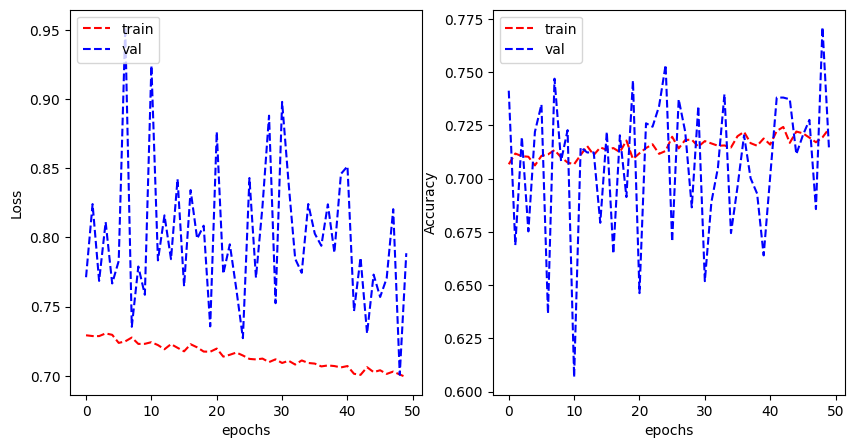

In [62]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

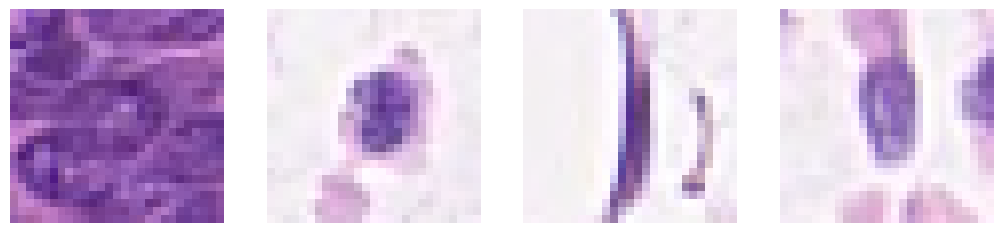

In [75]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in preprocessed_data['val_generator']:
        batches = batches + 1
        y_hat = model_VGG_1.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(np.squeeze(x[0]))
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [76]:
print(y_hat)

[[ 2.140203    1.7039552  -1.6480972  -1.1788434 ]
 [ 4.7330565  -0.95269567 -0.6558734  -0.41568494]
 [ 4.025491   -0.8435565  -0.4468423  -0.63425565]
 [-1.8296765   0.6105316   0.46487537  0.61453724]
 [-2.1103983  -0.18888627  1.2176689   0.557165  ]
 [ 3.19484     0.9924204  -1.5104116  -1.4765856 ]
 [-1.8315579   0.59055877  0.5834842   0.64686954]
 [ 3.6934314   0.03830314 -1.0835598  -1.1532569 ]
 [-1.2497071   1.0798398   0.02422075  0.3826685 ]
 [-0.6056117  -0.94857055  1.1852032   0.35706484]
 [-1.2832502   0.44458526  0.62991464  0.13147616]
 [ 2.0109096   0.85575336 -0.93708766 -0.9891821 ]
 [ 0.67102313 -1.6120884   1.3174279   0.36808783]
 [ 2.525179    1.0969121  -1.4147878  -1.2834646 ]
 [-1.7344176   1.3316839  -0.23529863  0.8120751 ]
 [-1.3927566   0.8657387   0.17776999  0.41356158]
 [-1.6426345   0.46831638  0.633512    0.2956904 ]
 [ 2.1370513   1.7210014  -1.7843542  -1.076262  ]
 [-0.8911166   0.96420676  0.25457832  0.03903176]
 [ 0.7739641   1.8012904  -1.38

Based on the values in the array you provided, it seems that the model is predicting label probabilities for each of the four possible classes for each input image. For example, the first row of the array shows the predicted label probabilities for the first input image, where the model assigned a higher probability to class 0 ("fibroblast") than to any of the other classes.

You can obtain the predicted label for each input image by taking the index with the highest probability in each row of the array, using the argmax function along axis 1. For example, to obtain the predicted labels for a batch of 10 images, you could do:

In [80]:
y_pred = np.argmax(y_hat, axis=1)
print(y_pred)

y_actual = np.argmax(y, axis=1)
print(y_actual)


[0 0 0 3 2 0 3 0 1 2 2 0 2 0 1 1 2 0 1 1 0 2 0 1 1 1 1 2 2 1 1 0]
[0 0 0 2 2 0 2 0 0 2 2 0 2 0 2 0 1 1 2 0 0 2 0 0 1 3 1 2 2 1 3 0]
